This is an updated and revised version of an [older post](https://rdkit.blogspot.com/2019/06/doing-extended-hueckel-calculations.html).

The RDKit has included an optional integration with a semi-empirical quantum mechanics package called YAeHMOP since the 2019.03 release. If you build the RDKit yourself, this is disabled by default, but it is part of the RDKit conda-forge and pypi builds, so it's available to most RDKit users.

There's no documentation for this integration yet... thus this blog post.


# Some background

One of my major projects in grad school was to write a software package for performing extended Hueckel calculations and analyzing and visualizing the results. I released the source for YAeHMOP ("Yet Another extended Hueckel Molecular Orbital Package") way back when using some weird license (the open-source landscape in chemistry was "a bit" different back in the mid-90s). After changing fields, I more or less forgot about YAeHMOP until a couple of years ago when Patrick Avery contacted me about integrating it [into Avogadro](https://pubs.acs.org/doi/abs/10.1021/acs.jchemed.7b00698). To make things easier, I put the source [up on Github](https://github.com/greglandrum/yaehmop) and switched to a BSD license. Since that point we've done a bit of additional cleanup work on the eHT code (the visualization pieces are still there, but really only have historic interest) and made it useable as a library.

There are a couple of applications where I think it might be interesting to have access to quick, interpretable QM results from the RDKit. These include getting partial charges and starting to think about quick and dirty descriptors for things like bond strengths and reactivity. So I decided to do an integration of YAeHMOP into the RDKit.

There are a *bunch* of books and papers describing extended Hueckel theory and the various types of analysis that one can do with it; I'm not going to cite all of those here. There's also no formal publication describing YAeHMOP (what a shock!), but there is a [chapter](https://drive.google.com/open?id=0BzBynnwxNS0SanJzUkJYYWNFY0h1bzNFR0d0aVBCR0x5NmZV) in my PhD thesis that provides an fairly comprehensive tutorial overview of the theory.


In [45]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem import rdMolAlign
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

# this is the package including the connection to YAeHMOP
from rdkit.Chem import rdEHTTools


import numpy as np

import rdkit
print(rdkit.__version__)
import time
print(time.asctime())


2025.03.2
Tue May 27 06:32:31 2025


In [25]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '16'
%matplotlib inline

# Running an eHT calculation

Start by showing how to run an eHT calculation:

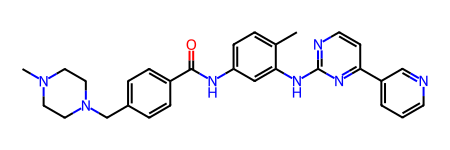

In [5]:
# imatinib
m = Chem.MolFromSmiles('Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1')
m

We need to add Hs and generate a conformation:

In [6]:
mh = Chem.AddHs(m)

params = rdDistGeom.ETKDGv3()
params.randomSeed = 0xf00d
_ = rdDistGeom.EmbedMultipleConfs(mh,50,params);

And now we can run the calculation, it's quick:

In [7]:
passed,res = rdEHTTools.RunMol(mh)

The first return value lets us know if the calculation succeeded:

In [8]:
passed

True

The second contains the results of the calculation:

In [9]:
res

We have access to the atomic charges:

In [10]:
res.GetAtomicCharges()

array([-5.73319770e-02, -1.56119578e-02, -4.62356988e-02, -1.18071986e-01,
        2.86923770e-01, -3.70969432e-01,  1.00722260e+00, -1.21427336e+00,
        1.03464336e-02,  3.95206419e-03, -5.19248775e-02,  1.13588339e-01,
        2.38359626e-01, -5.99954120e-01,  2.17722688e-01,  2.27807128e-01,
       -6.56662561e-01,  1.84484934e-01,  2.16303717e-01,  2.04326750e-01,
       -6.48170370e-02,  3.50318427e-03, -1.46944980e-01,  2.80281190e-01,
       -3.39480974e-01,  9.28885393e-01, -9.10924655e-01,  4.27524493e-01,
       -1.53696399e-01,  4.99938553e-01,  1.25460394e-02,  1.04297689e-01,
       -5.89901215e-02,  3.62195210e-01, -8.17714649e-01,  3.65798320e-01,
       -9.06432708e-01,  2.36395863e-02,  2.09410831e-02,  1.39448705e-02,
        1.96396053e-02,  3.16035160e-02,  2.28935259e-01,  2.99088433e-02,
        2.12441191e-02, -9.34616751e-03, -1.93856802e-02,  1.28332398e-03,
       -3.10220683e-03, -4.19893941e-03, -2.37810660e-03,  1.00680225e-02,
        1.90934569e-03,  

The reduced overlap population matrix provides the Mulliken overlap population between atoms in the molecule. This tells us something about the strength of the interaction between the atoms. It's returned as a vector representing a symmetric matrix:

In [12]:
res.GetReducedOverlapPopulationMatrix()[:6]

array([ 2.58800014,  0.7866103 ,  2.78382058, -0.08743666,  1.12740458,
        2.72952681])

In [13]:
# convenience function to set a "MulilkenOverlapPopulation" property on bonds.
def set_overlap_populations(m,ehtRes):
    rop = ehtRes.GetReducedOverlapPopulationMatrix()
    for bnd in m.GetBonds():
        a1 = bnd.GetBeginAtom()
        a2 = bnd.GetEndAtom()
        if a1.GetAtomicNum()==1 or a2.GetAtomicNum()==1:
            continue
        # symmetric matrix:
        i1 = max(a1.GetIdx(),a2.GetIdx())
        i2 = min(a1.GetIdx(),a2.GetIdx())
        idx = (i1*(i1+1))//2 + i2
        bnd.SetDoubleProp("MullikenOverlapPopulation",rop[idx])


In [14]:
set_overlap_populations(mh,res)

Look at a few of the overlap populations:

In [15]:
for bnd in list(mh.GetBonds())[:5]:
    if not bnd.HasProp("MullikenOverlapPopulation"):
        continue
    print(f'{bnd.GetIdx()} {bnd.GetBeginAtom().GetSymbol()}({bnd.GetBeginAtomIdx()})-{bnd.GetEndAtom().GetSymbol()}({bnd.GetEndAtomIdx()}) {bnd.GetBondType()} {bnd.GetDoubleProp("MullikenOverlapPopulation") :.3f}')

0 C(0)-C(1) SINGLE 0.787
1 C(1)-C(2) AROMATIC 1.127
2 C(2)-C(3) AROMATIC 1.084
3 C(3)-C(4) AROMATIC 1.113
4 C(4)-N(5) SINGLE 0.720


The wrapper also currently provides the reduced charge matrix (described in that thesis chapter linked above). I'm not going to discuss that here.

# Application: Look at variability of charges between conformers

The rest of this blog post is going to show a straightforward analysis one can do with the eHT results: looking at the variability of the QM charges across the different conformers.

In [16]:
def runEHT(mh):
    """ convenience function to run an eHT calculation on all of a molecule's conformers
    
        returns a list of the results structures as well as a list of lists containing the
        charges on each atom in each conformer: chgs[atomId][confId] to use this
    """
    eres = []
    charges = [[] for x in range(mh.GetNumHeavyAtoms())]
    for cid in range(mh.GetNumConformers()):
        passed,res = rdEHTTools.RunMol(mh,confId=cid)
        eres.append(res)
        if not passed:
            raise ValueError("eHT failed")
        hvyIdx = 0
        echgs = res.GetAtomicCharges()
        for atom in mh.GetAtoms():
            if atom.GetAtomicNum()==1:
                continue
            charges[hvyIdx].append(echgs[atom.GetIdx()])
            hvyIdx+=1
    return (eres,charges)
    

In [17]:
eres,charges = runEHT(mh)

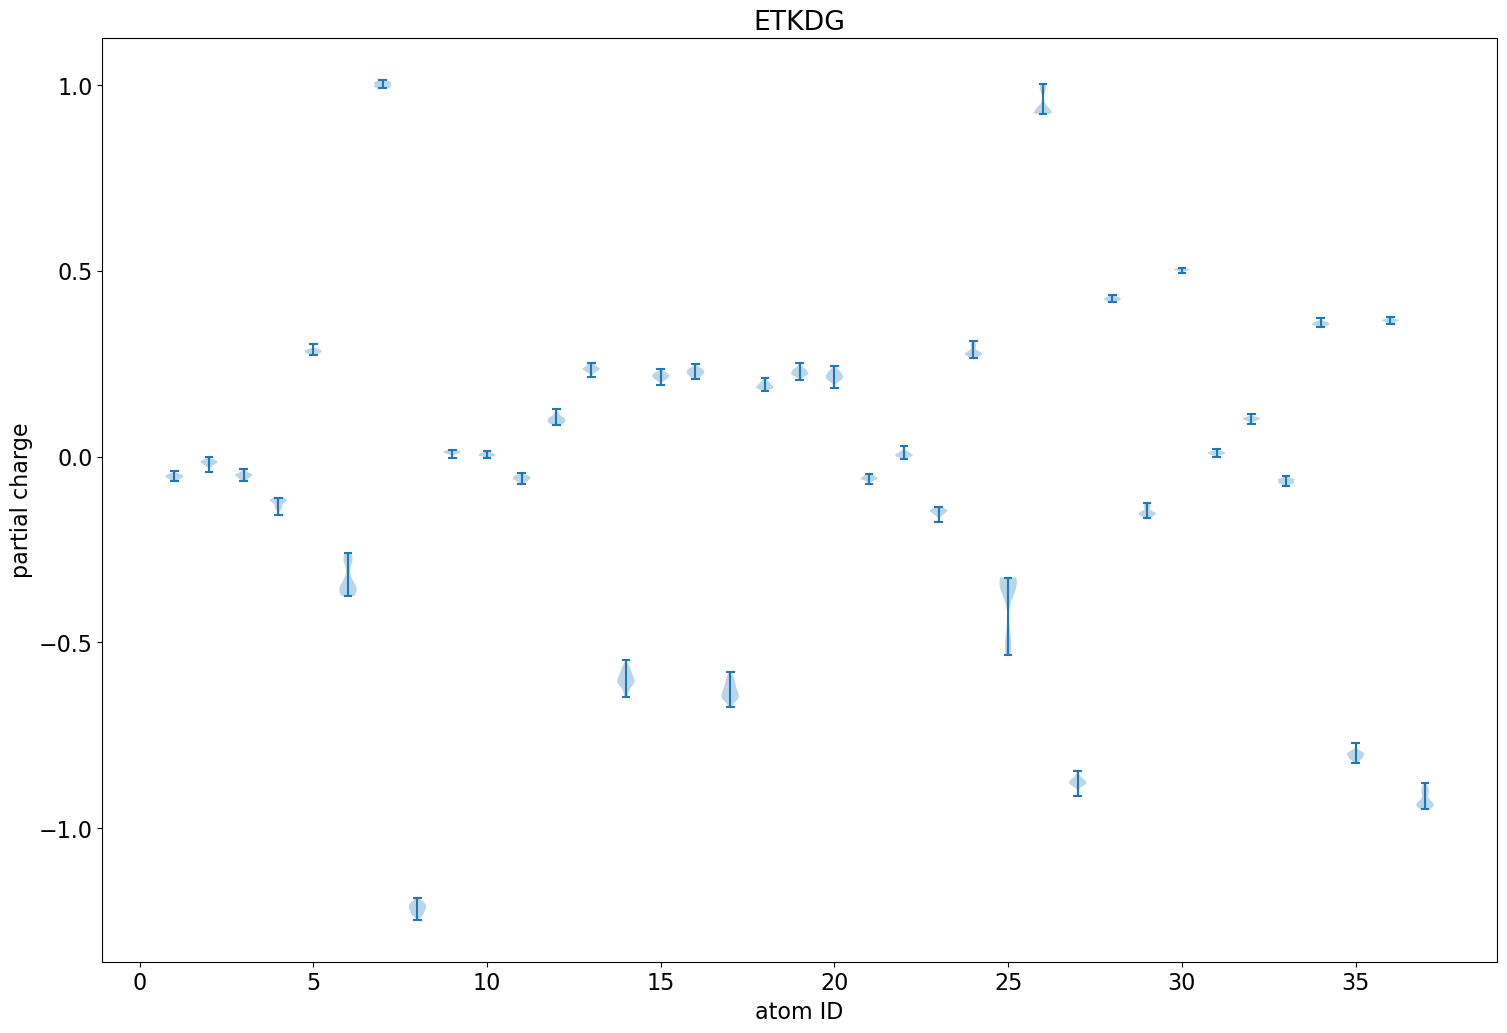

In [26]:
plt.figure(figsize=(18,12))
plt.violinplot(charges);
plt.title("ETKDG");
plt.xlabel('atom ID');
plt.ylabel("partial charge");

To make sense of that, draw the molecule with the atoms numbered:

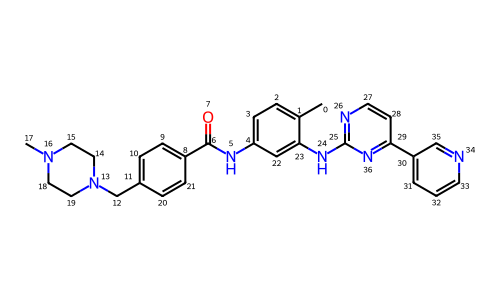

In [23]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,300
m

Look at the results for a couple of the atoms that show the most variability

In [29]:
chgRange = [max(x)-min(x) for x in charges]
sortedRanges = sorted([(y,x) for x,y in enumerate(chgRange)], reverse=True)
sortedRanges[:2]

[(0.20875282639970938, 24), (0.11463855830843706, 5)]

In [30]:
tchgs = sorted((y,x) for x,y in enumerate(charges[24]))
tchgs[:2],tchgs[-2:]

([(-0.5344846663677152, 7), (-0.5300694785153464, 9)],
 [(-0.3297127630789536, 46), (-0.3257318399680058, 22)])

In [31]:
tchgs = sorted((y,x) for x,y in enumerate(charges[5]))
tchgs[:2],tchgs[-2:]

([(-0.37553939142960324, 12), (-0.3740573280350843, 4)],
 [(-0.2660340113875628, 14), (-0.2609008331211662, 30)])

Look at the two conformers where the charges on atom 24 differ the most:

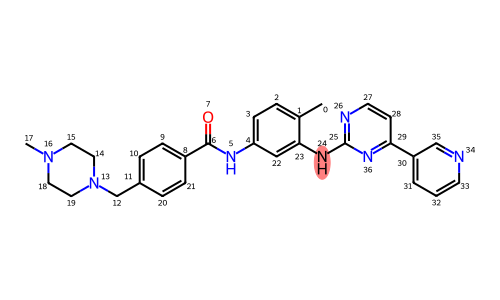

In [34]:
m.__sssAtoms = [24]
m

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

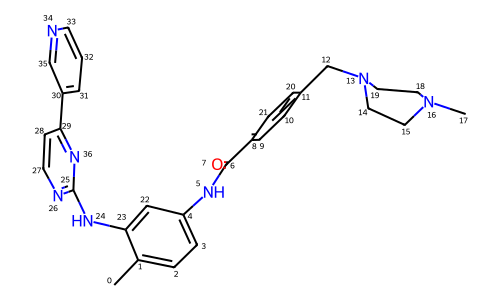

In [32]:
tm7 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=7))
tm7

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

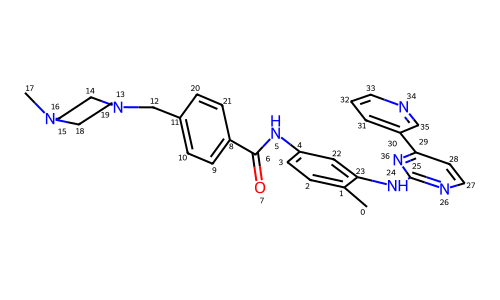

In [33]:
tm22 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=22))
tm22

The difference here is the relative orientations of the two aromatic rings that N24 is bonded to. In the first case (more negative N), the rings are perpendicular to each other. In the second (less negative N), they are parallel.

What if we do an MMFF minimization of each conformer?

In [37]:
mh_mmff = Chem.Mol(mh)
optRes = rdForceFieldHelpers.MMFFOptimizeMoleculeConfs(mh_mmff,maxIters=500)
for i,needsMore in enumerate(optRes):
    while needsMore:
        needsMore = rdForceFieldHelpers.MMFFOptimizeMolecule(mh_mmff,maxIters=500,confId=i)


In [38]:
eres,mmff_charges = runEHT(mh_mmff)

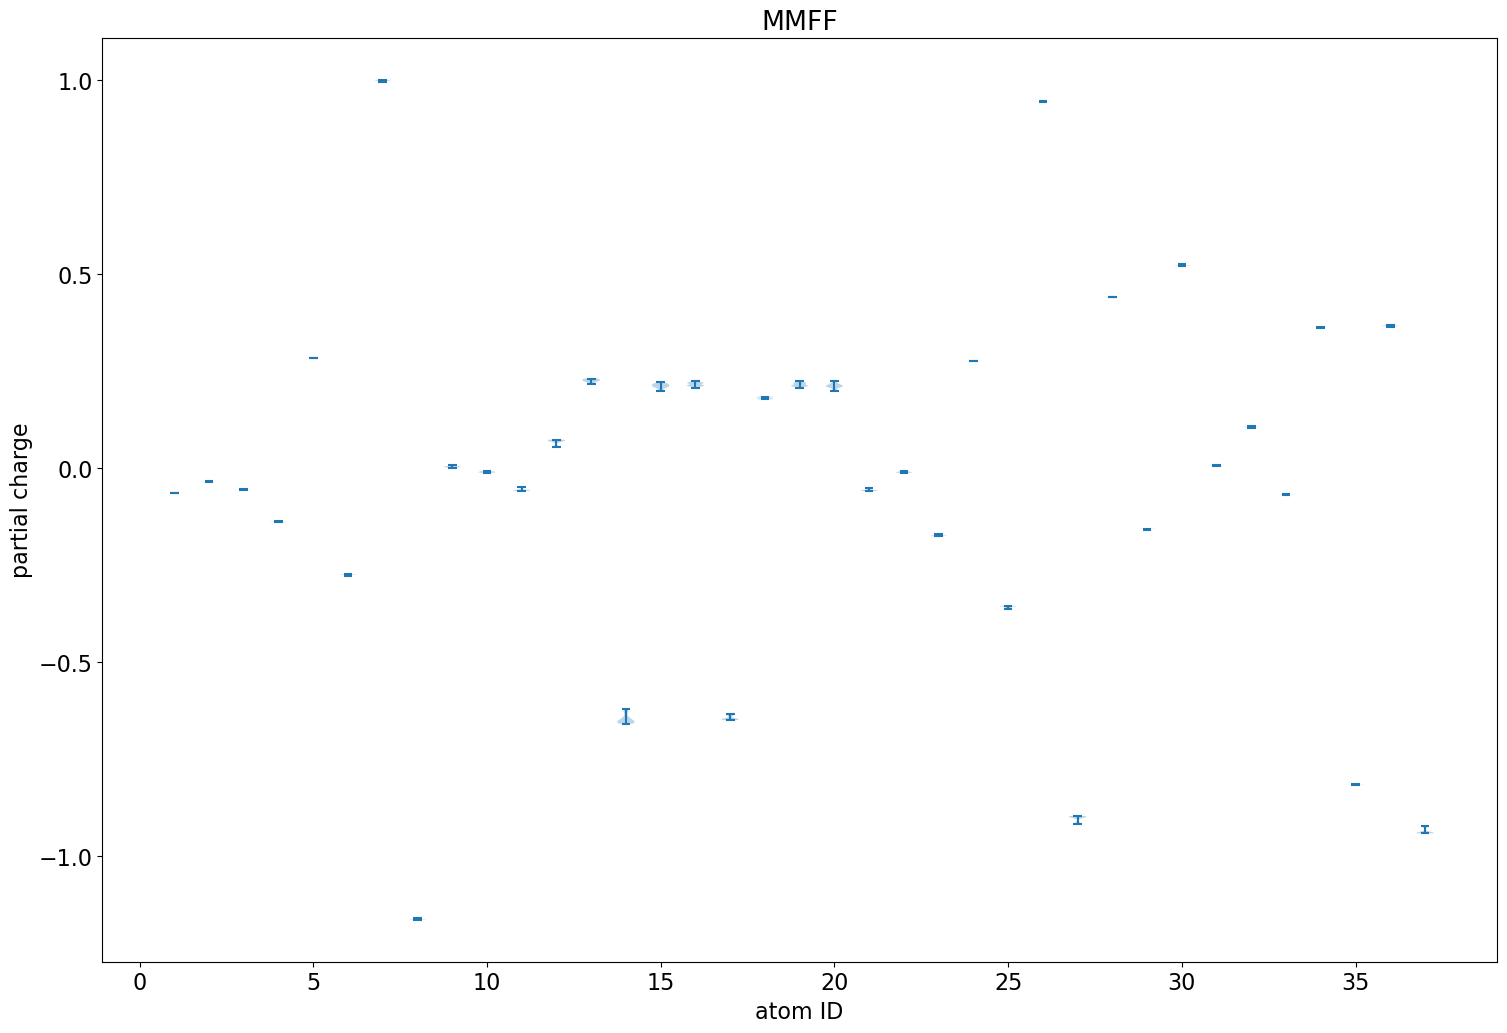

In [39]:
plt.figure(figsize=(18,12))
plt.violinplot(mmff_charges);
plt.title("MMFF");
plt.xlabel('atom ID');
plt.ylabel("partial charge");

In [40]:
chgRange = [max(x)-min(x) for x in mmff_charges]
sortedRanges = sorted([(y,x) for x,y in enumerate(chgRange)], reverse=True)
sortedRanges[:2]

[(0.03803692881100473, 13), (0.025728042579126975, 19)]

Those are much smaller changes (as we saw in the distributions).

What about the N24, the atom we looked at above?

In [41]:
tchgs = sorted((y,x) for x,y in enumerate(charges[24]))
tchgs[:2],tchgs[-2:]

([(-0.5344846663677152, 7), (-0.5300694785153464, 9)],
 [(-0.3297127630789536, 46), (-0.3257318399680058, 22)])

Almost no difference at all there. Are the neighboring rings now consistently orented?

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

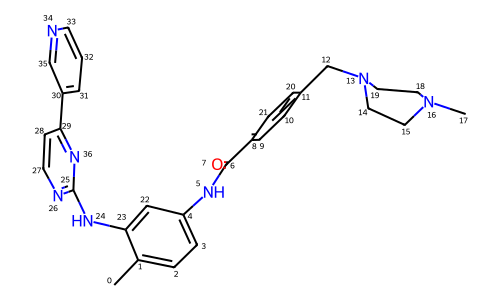

In [43]:
tm7 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=7))
tm7

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

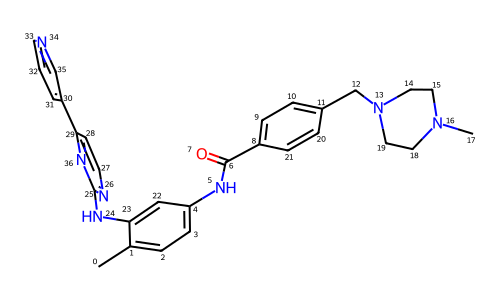

In [44]:
tm9 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=9))
tm9

They are: the rings are more or less perpendicular in both conformers.

The charge variability has dropped considerably, are the MMFF conformers actually different from each other?

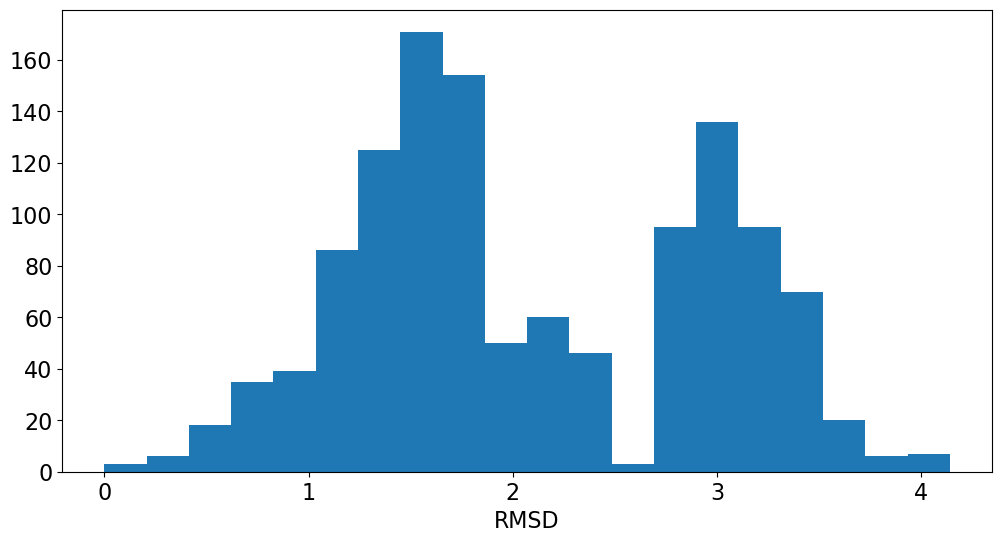

In [49]:
rmsds = []
cp1 = Chem.RemoveHs(mh_mmff)
cp2 = Chem.RemoveHs(mh_mmff)
for i in range(mh_mmff.GetNumConformers()):
    for j in range(i+1,mh_mmff.GetNumConformers()):
        rmsds.append(rdMolAlign.GetBestRMS(cp1,cp2,prbId=i,refId=j))
plt.figure(figsize=(12,6))
plt.hist(rmsds,bins=20);
plt.xlabel('RMSD');

So the conformers are still different from each other but the charge differences are now much smaller than they were previously.

# Repeat the analysis for another molecule

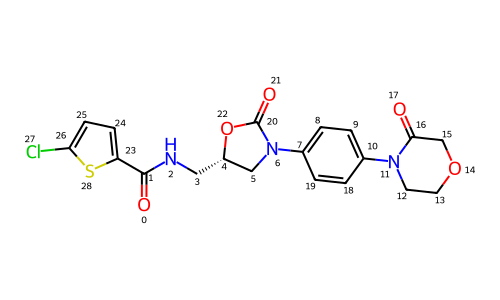

In [52]:
# rivaroxaban
m2 = Chem.MolFromSmiles('O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1ccc(Cl)s1')
m2

In [55]:
mh2 = Chem.AddHs(m2)
rdDistGeom.EmbedMultipleConfs(mh2,50,params)
mh2_mmff = Chem.Mol(mh2)
optRes = rdForceFieldHelpers.MMFFOptimizeMoleculeConfs(mh2_mmff,maxIters=500)
for i,needsMore in enumerate(optRes):
    while needsMore:
        needsMore = rdForceFieldHelpers.MMFFOptimizeMolecule(mh2_mmff,maxIters=500,confId=i)


In [56]:
eres,charges2 = runEHT(mh2)
eres,mmff_charges2 = runEHT(mh2_mmff)


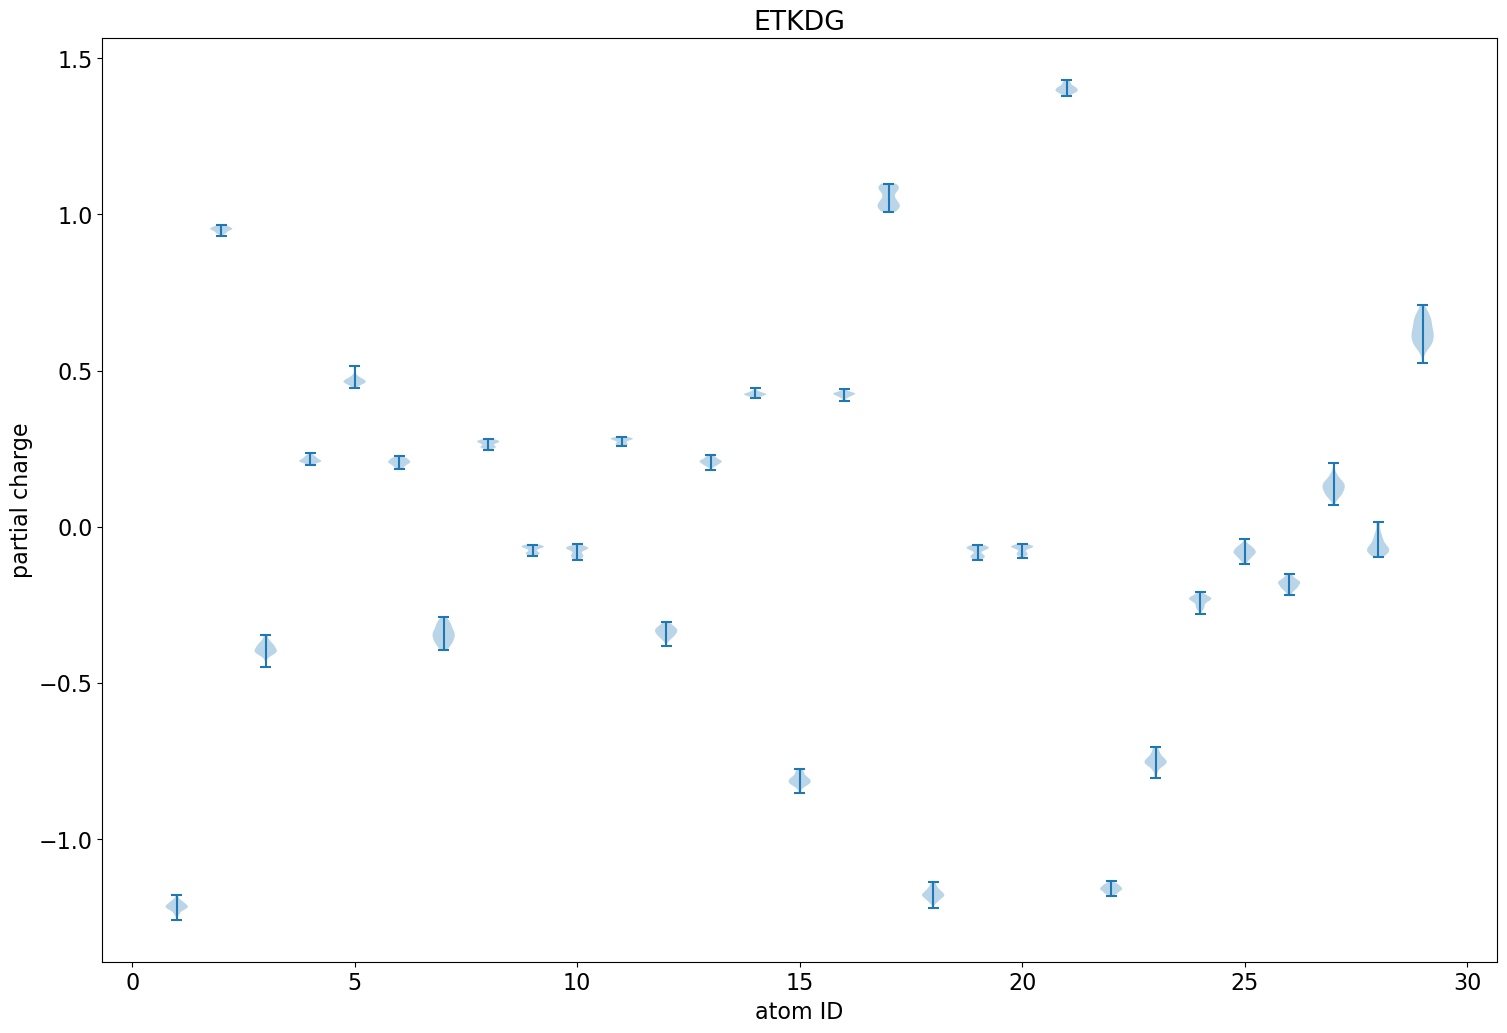

In [57]:
plt.figure(figsize=(18,12))
plt.violinplot(charges2);
plt.title("ETKDG");
plt.xlabel('atom ID');
plt.ylabel("partial charge");

Less variability than we had with the ETKDG conformers of imatinib, but there is still some. This almost entirely vanishes when using the MMFF-optimized conformers:

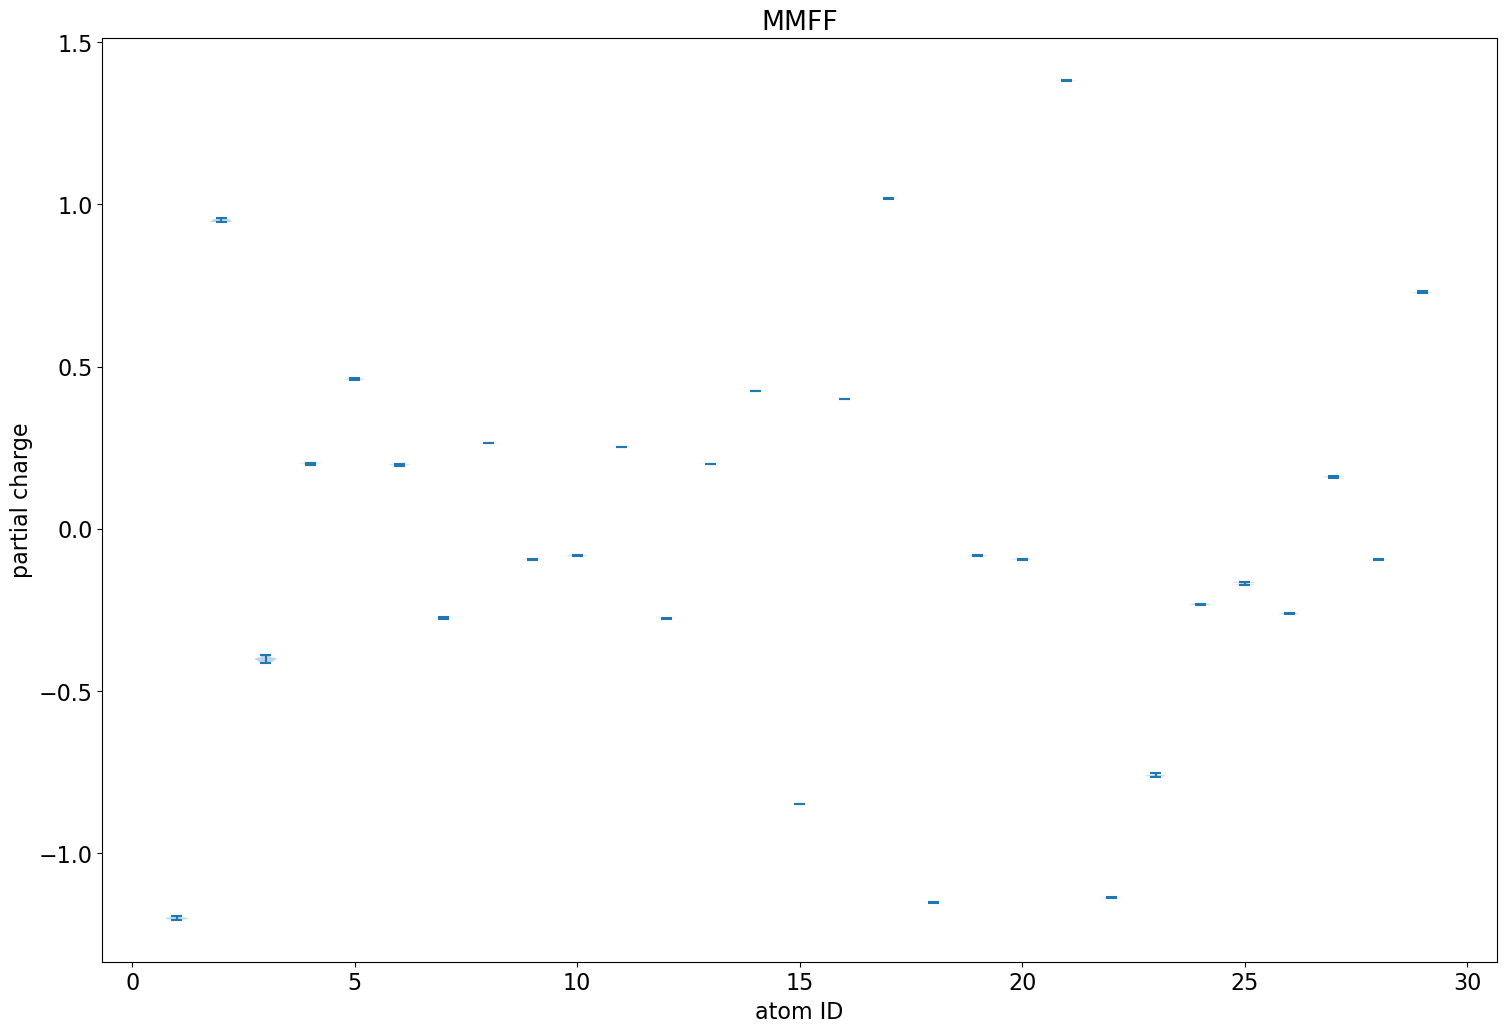

In [58]:
plt.figure(figsize=(18,12))
plt.violinplot(mmff_charges2);
plt.title("MMFF");
plt.xlabel('atom ID');
plt.ylabel("partial charge");

Confirm again that the MMFF conformers actually different:

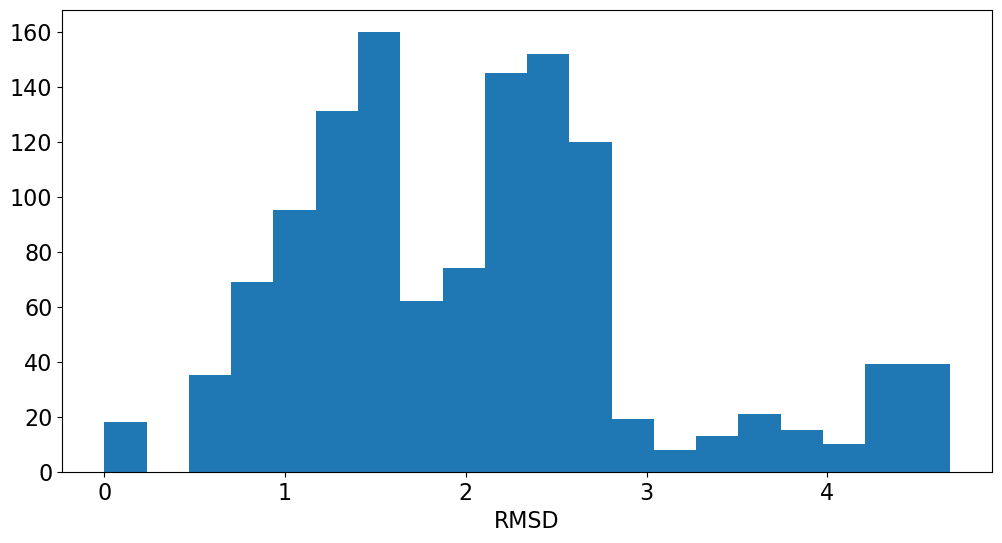

In [60]:
rmsds = []
cp1 = Chem.RemoveHs(mh2_mmff)
cp2 = Chem.RemoveHs(mh2_mmff)
for i in range(mh2_mmff.GetNumConformers()):
    for j in range(i+1,mh2_mmff.GetNumConformers()):
        rmsds.append(rdMolAlign.GetBestRMS(cp1,cp2,prbId=i,refId=j))
plt.figure(figsize=(12,6))
plt.hist(rmsds,bins=20);
plt.xlabel('RMSD');

They are.

# Performance

How long does it take to do this analysis?

Start by looking at the time required to generate a conformer:

In [62]:
tempM = Chem.Mol(mh2)
%timeit _ = rdDistGeom.EmbedMolecule(tempM,params)

22 ms ± 164 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Or to generate a conformer and MMFF minimize it:

In [63]:
%timeit _ = rdDistGeom.EmbedMolecule(tempM,params);rdForceFieldHelpers.MMFFOptimizeMolecule(tempM,maxIters=500)

40.3 ms ± 391 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Do the eHT calculation:

In [64]:
%timeit _ = rdEHTTools.RunMol(tempM)

19.4 ms ± 51.5 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we can generate a conformer for rivaroxaban, MMFF minimize it, and then do the eHT calculation to get, for example, partial charges (remember these don't seem to change that much across MMFF conformers) in about 60ms. Not bad!